### Librerias

In [19]:
using SymPy
using Interpolations
using Plots
using CSV
using DataFrames
using Statistics
using PyCall

Obtener input del día para la predicción.

In [20]:
println("Introduzca el punto (día) a evaluar.")
day = try
    parse(Float64, readline())
catch
    "8"
end

Introduzca el punto (día) a evaluar.


stdin>  10


10.0

### Datos de temperaturas por Dia

In [21]:
function GetTemperaturas(data)
    promedios = []
    for fila in eachrow(data)
        #Datos de temperatura a partir de la segunda columna.
        #Mean para calcular el promedio de las temperaturas dentro de la fila.
        promedio = mean(fila[2:end])
        push!(promedios, promedio)
    end
    return promedios
end

#Leer el archivo CSV
data = CSV.read("temperaturas.csv", DataFrame, header=0)

#Dias en la primera columna.
dias = data[:, 1] 

temperaturas = GetTemperaturas(data)

7-element Vector{Any}:
 23.333333333333332
 24.0
 25.0
 25.666666666666668
 27.0
 22.0
 23.0

### Funciones para Calcular Rangos de dias

In [22]:
#Función para obtener los puntos a evaluar dentro del rango de días
function DiasInterpolados(punto = 7)
    return range(minimum(dias), punto, length=100)
end

function DiasInterpolados2(punto)
    if punto < 7
        return DiasInterpolados()
    else
        return DiasInterpolados(punto)
    end
end

DiasInterpolados2 (generic function with 1 method)

### Interpolación de Taylor

## Explicación del Código (Procedimiento)

### Definición de la Función `DiasInterpolados2(punto)`
Esta función determina el rango de días en los que se realizará la interpolación.
- Si el punto de evaluación es menor que 7, el rango se extiende desde el día mínimo hasta el día 7.
- De lo contrario, el rango se extiende desde el día mínimo hasta el punto de evaluación.

### Construcción de la Función Interpolada (Lagrange)
La función `funcion_interpolada` se construye utilizando el método de interpolación de Lagrange. Para cada día, se calcula un término que se suma a la función interpolada.

### Parámetros para el Polinomio de Taylor
Se solicita al usuario que ingrese el punto de evaluación y el grado del polinomio de Taylor.

### Función `polinomio_taylor(funcion, punto, grado)`
Esta función calcula el polinomio de Taylor alrededor del punto de evaluación para la función dada y con el grado especificado. Se utilizan las derivadas de la función en el punto de evaluación para calcular los términos del polinomio.

### Calculando el Polinomio de Taylor
Se calcula el polinomio de Taylor utilizando la función `polinomio_taylor` con los parámetros especificados.

### Predicción de Temperatura
Se solicita al usuario que ingrese el valor que desea predecir. Luego, se evalúa el polinomio de Taylor en este valor para obtener la predicción de temperatura.

### Graficando los Resultados
Se grafican los datos originales, la función interpolada y el polinomio de Taylor para visualizar los resultados.

### Fórmula Utilizada:

La fórmula utilizada para calcular el polinomio de Taylor es:

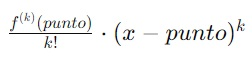


### donde: 

- `f^(k)` (punto) representa la `k-enesima derivada` de la función evaluada en el punto y  grado es el grado del polinomio de Taylor.

### Código Completo

Coloque punto a evaluar: 

stdin>  7


Coloque grado: 

stdin>  7


Temperatura en el día 10.0 con interpolación taylor: 26.0°C


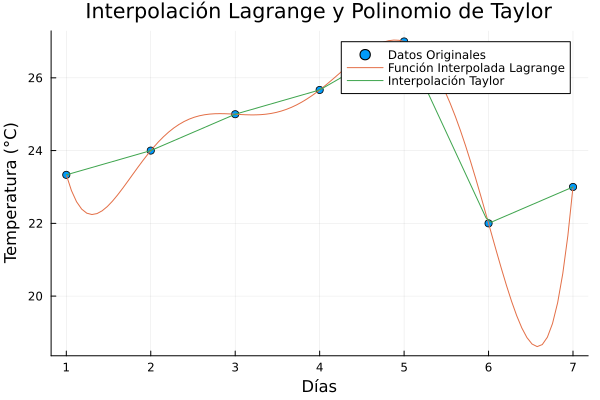

Temperatura en el día 8.0 con interpolación taylor: 24.0°C


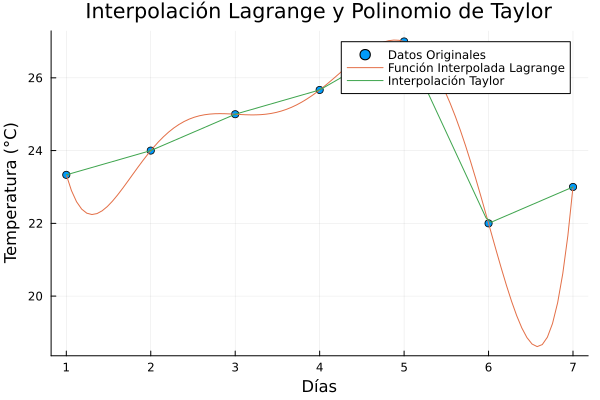

In [23]:
# Construir la función interpolada (Lagrange)
function LagrangePolinomica(dias, temperaturas)
    x = symbols("x")
    n = length(dias)
    polinomio = 0
    for i in 1:n
        term = temperaturas[i]
        for j in 1:n
            if i != j
                term *= (x - dias[j]) / (dias[i] - dias[j])
            end
        end
        polinomio += term
    end
    return simplify(polinomio)
end

# Función para calcular el polinomio de Taylor
function taylor(func, punto, grado)
    x = symbols("x")
    polinomio_taylor = 0
    for k in 0:grado
        derivada_k = diff(func, x, k)
        derivada_punto = subs(derivada_k, x, punto)
        termino_k = (derivada_punto / factorial(k)) * (x - punto)^k
        polinomio_taylor += termino_k
    end
    return simplify(polinomio_taylor)
end

# Función de interpolación por trozos usando Taylor
function Taylor_Casos(dias, temperaturas, cantidad_interpolar, punto_taylor, grado_taylor)
    x = symbols("x")
    
    for i in 1:length(dias)-1
        if cantidad_interpolar >= dias[i] && cantidad_interpolar <= dias[i+1]
            funcion = LagrangePolinomica(dias[i:i+1], temperaturas[i:i+1])
            polinomio_taylor = taylor(funcion, punto_taylor, grado_taylor)
            polinomio_taylor_eval = lambdify(polinomio_taylor, [x])
            return polinomio_taylor_eval(cantidad_interpolar)
        end
    end

    # Casos de extrapolación
    if cantidad_interpolar < dias[1]
        funcion = LagrangePolinomica(dias[1:2], temperaturas[1:2])
        polinomio_taylor = taylor(funcion, punto_taylor, grado_taylor)
        polinomio_taylor_eval = lambdify(polinomio_taylor, [x])
        return polinomio_taylor_eval(cantidad_interpolar)
    end

    if cantidad_interpolar > dias[end]
        funcion = LagrangePolinomica(dias[end-1:end], temperaturas[end-1:end])
        polinomio_taylor = taylor(funcion, punto_taylor, grado_taylor)
        polinomio_taylor_eval = lambdify(polinomio_taylor, [x])
        return polinomio_taylor_eval(cantidad_interpolar)
    end

    return NaN
end

# Función para imprimir la predicción de la temperatura en un día específico
function PrintPrediccion(dias, temperaturas, day, punto_taylor, grado_taylor)
    println("Temperatura en el día $day con interpolación taylor: ",Taylor_Casos(dias, temperaturas, day, punto_taylor, grado_taylor),"°C")
end

temperaturas_interpoladas = []
# Función para imprimir las temperaturas interpoladas
function PrintTemperaturasInterpoladas(dias, temperaturas, punto_taylor, grado_taylor, label = "Taylor")
    dias_interpolados = DiasInterpolados()
    for cantidad_interpolar in dias_interpolados
        # Calcular la temperatura interpolada para el día actual
        temp_interpolada = Taylor_Casos(dias, temperaturas, cantidad_interpolar, punto_taylor, grado_taylor)
        
        # Agregar la temperatura interpolada a la lista
        push!(temperaturas_interpoladas, temp_interpolada)
    end

    x = symbols("x")
    funcion = LagrangePolinomica(dias, temperaturas)
    funcion_eval = lambdify(funcion, [x])
    y_vals_interp = [funcion_eval(dia) for dia in dias_interpolados]

    # Graficar los datos originales, la interpolación de Lagrange y la interpolación de Taylor
    plot(dias, temperaturas, seriestype=:scatter, label="Datos Originales", markershape=:circle)
    plot!(dias_interpolados, y_vals_interp, label="Función Interpolada Lagrange")
    plot!(dias_interpolados, temperaturas_interpoladas, label="Interpolación Taylor")
    xlabel!("Días")
    ylabel!("Temperatura (°C)")
    title!("Interpolación Lagrange y Polinomio de Taylor")
end

# Parámetros para el polinomio de Taylor
print("Coloque punto a evaluar: ")
punto_taylor = parse(Float64, readline())
print("Coloque grado: ")
grado_taylor = parse(Int64, readline())


# Imprimir predicción
PrintPrediccion(dias, temperaturas, day, punto_taylor, grado_taylor)

# Imprimir temperaturas interpoladas
PrintTemperaturasInterpoladas(dias, temperaturas, punto_taylor, grado_taylor)

### Interpolación de Lagrange

### La fórmula de Lagrange que se está utilizando en el código es la siguiente:

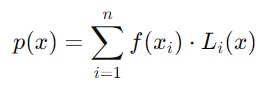  

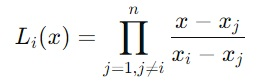


### Donde:

- `p(x)` = es el polinomio de Lagrange
- `n` es el numero de puntos dados
- `Li(x)` es el término de Lagrange para el punto xi dado por:


    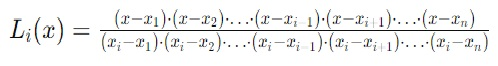
    

- `f(xi)` es el valor de la funcion xi que en este caso es la temperatura registrada en el día xi

Esta fórmula calcula el polinomio de Lagrange que pasa por todos los puntos de datos dados y se utiliza para predecir valores intermedios entre estos puntos.


### Descripción del Código

#### Inicialización de Variables
- `n`: Número de puntos de datos.
- `x`: Variable simbólica.
- `polinomio`: Inicialización del polinomio de Lagrange.

#### Función DiasInterpolados
Esta función determina el rango de días sobre los cuales se realizará la interpolación.
- Si el día deseado está más allá del séptimo día, el rango se extiende hasta ese día, de lo contrario, se extiende hasta el día 7.

#### Cálculo del Polinomio de Lagrange
Se itera sobre cada punto de datos para calcular los términos de Lagrange y el polinomio resultante. 

#### Simplificación del Polinomio de Lagrange
Se simplifica el polinomio resultante.

#### Evaluación Numérica del Polinomio de Lagrange
Se define una función que permite evaluar el polinomio en un valor específico de `x`.

#### Ingreso de la Predicción por Teclado
El usuario ingresa el valor del día para el cual se desea realizar la predicción.

#### Generación de Puntos para la Gráfica
Se determina el rango de días sobre los cuales se graficarán los resultados de la interpolación.

#### Predicción e Impresión
Se realiza la predicción de temperatura para el día ingresado por el usuario y se imprime el resultado.

#### Gráfico
Se grafican los datos originales, la interpolación de Lagrange y los puntos de datos registrados.

### Código Completo

Temperatura en el día 10.0 con interpolación Lagrange: 26.0°C


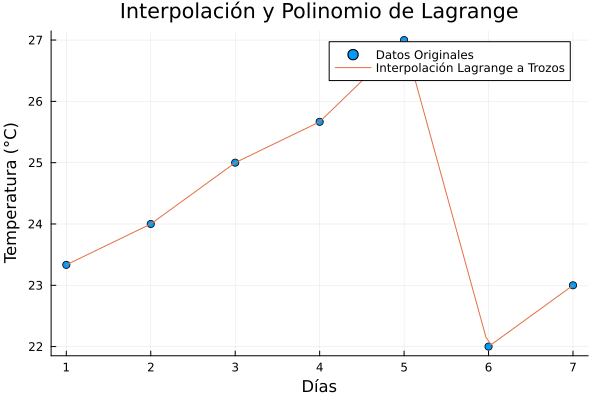

In [24]:
# Construir la función interpolada (Lagrange)
function LagrangePolinomica(dias, temperaturas, cantidad)
    n = length(dias)
    polinomio = 0
    for i in 1:n
        term = temperaturas[i]
        for j in 1:n
            if i != j
                term *= (cantidad - dias[j]) / (dias[i] - dias[j])
            end
        end
        polinomio += term
    end
    return polinomio
end

# Función de interpolación por trozos usando Lagrange
function LagrangeInterpolacionTrozos(dias, temperaturas, cantidad_interpolar)
    for i in 1:length(dias)-1
        if cantidad_interpolar >= dias[i] && cantidad_interpolar <= dias[i+1]
            return LagrangePolinomica(dias[i:i+1], temperaturas[i:i+1], cantidad_interpolar)
        end
    end

    # Casos de extrapolación
    if cantidad_interpolar < dias[1]
        return LagrangePolinomica(dias[1:2], temperaturas[1:2], cantidad_interpolar)
    end

    if cantidad_interpolar > dias[end]
        return LagrangePolinomica(dias[end-1:end], temperaturas[end-1:end], cantidad_interpolar)
    end

    return NaN
end

# Función para imprimir la predicción de la temperatura en un día específico
function PrintPrediction(dias, temperaturas, day, label = "Lagrange")
    println("Temperatura en el día $day con interpolación $label: ", LagrangeInterpolacionTrozos(dias, temperaturas, day),"°C")
end

# Función para imprimir las temperaturas interpoladas
function PrintTemperaturasInterpoladas(dias, temperaturas, label = "Lagrange")
    dias_interpolados = DiasInterpolados()
    temperaturas_interpoladas = [LagrangeInterpolacionTrozos(dias, temperaturas, cantidad_interpolar) for cantidad_interpolar in dias_interpolados]

    plot(dias, temperaturas, seriestype=:scatter, label="Datos Originales", markershape=:circle)
    plot!(dias_interpolados, temperaturas_interpoladas, label="Interpolación $label a Trozos")
    xlabel!("Días")
    ylabel!("Temperatura (°C)")
    title!("Interpolación y Polinomio de Lagrange")
end

# Imprimir predicción
PrintPrediction(dias, temperaturas, day)

# Imprimir temperaturas interpoladas
PrintTemperaturasInterpoladas(dias, temperaturas)

### Interpolación de Hermite:

La interpolación de Hermite es un método en matemáticas que se utiliza paraconstruir un polinomio 
que no solo coincide con los valores de una función en un conjunto dado de puntos, sino que también
coincide con las derivadas de la función en esos puntos. Este tipo de interpolación es
especialmente útil cuando se conoce no solo la posición de los puntos, sino también la
pendiente (o derivada) de la curva en esos puntos. Se puede utilizar para una variedad de propósitos, incluida la aproximación de funciones y la generación de curvas que pasan a través de puntos de datos específicos.

Fórmula: Dado un conjunto de n puntos de datos (xi,yi)(xi​,yi), donde xi son las coordenadas "x" y yi son las coordenadas "y", y se conocen las derivadas f′(xi) en estos puntos, la fórmula para el polinomio interpolante de Hermite H(x) es la siguiente:

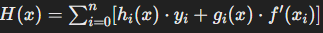

Dónde hi(x) son los polinomios de Hermite de interpolación y gi(x) son los polinomios de Hermite de interpolación para las derivadas.

### Cómo se implementó la fórmula en el código:


`"function calcular_derivadas(x, y)":` Esta función calcula las derivadas de la función de temperatura respecto a los días utilizando el método de diferencias finitas. Esto se hace mediante el uso de la función gradient de NumPy para calcular la derivada.

`"function calculo_diferencias(nodos, funcion, funcion_derivada)":` Esta función calcula las diferencias divididas necesarias para la interpolación de Hermite. Toma como entrada los nodos (en este caso, los días), la función (en este caso, las temperaturas), y las derivadas de la función en esos nodos. Después, se usan las diferencias divididas para generar los coeficientes necesarios para el polinomio de Hermite.

`"function hermite_polinomio(coeficientes , nodosDuplicados)":` Agarra los coeficientes calculados por la función anterior para generar el polinomio interpolante de Hermite.

`"function hermite(polinomio, diasx)":`  Esta función toma el polinomio de Hermite generado y un conjunto de días. Después, se evalúa el polinomio en estos días para obtener las temperaturas interpoladas.

Luego usando la misma "function hermite(polinomio, diasx)" introducimos como parámetro el día que queramos para predecir su temperatura. Finalmente graficamos los datos originales junto a los datos interpolados. 






La predicción de la temperatura para el día No se pudo encontrar una predicción válida.°C


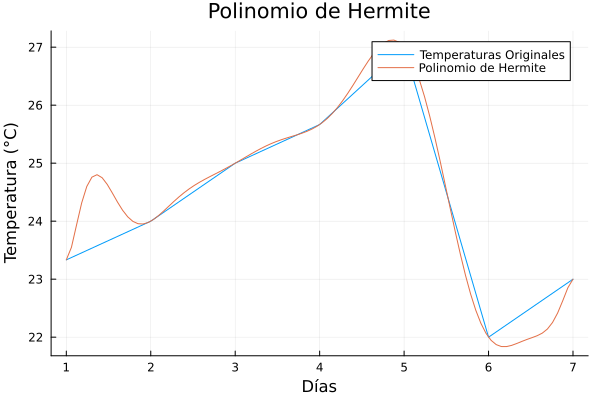

In [25]:
x = symbols("x")
# Graficar los datos originales
plot(dias, temperaturas, xlabel="Días", ylabel="Temperatura (°C)", label="Temperaturas Originales")

# Importamos NumPy
np = pyimport("numpy")

# Función para calcular derivadas usando diferencias finitas
function calcular_derivadas(x, y)
    # Convertimos los datos de los parámetros de la función a arrays de NumPy
    x_numpy = np.array(x)
    y_numpy = np.array(y)
    derivada_numpy = np.gradient(y_numpy,x_numpy) # Calcula la derivada (diferencia finita)
    # Convertir las derivadas de numpy a un arreglo de Julia
    dy = Float64.(derivada_numpy)
    return dy
end

# Usamos la función "calcular_derivadas"
derivadas = calcular_derivadas(dias, temperaturas)


# Calcular diferencias divididas 
function calculo_diferencias(nodos, funcion, funcion_derivada)
    # Almacenamos el número de nodos (puntos donde se intersectan las funciones y sus derivadas)
    numNodos = length(nodos) 
    #= Definimos los arreglos para nodos duplicados y matriz de diferencias divididas
    Sabiendo que undef significa que los elementos del arreglo no están inicializados.
    Además, entendamos que lo necesario son 2*numNodos ya que en Hermite se duplican 
    los nodos orginales para la información tanto de la función como la de su derivada.
    =#
    nodosDuplicados = Array{Float64}(undef, 2*numNodos) # 2*numNodos es el número total de nodos duplicados que se necesitan. 
    matrizDif = Array{Float64}(undef, 2*numNodos, 2*numNodos) # 2*numNodos son el número de filas y columnas de la matriz
    coeficientes = Array{Float64}(undef, 2*numNodos) # 2*numNodos son los coeficientes necesarios 

    
    for i in 0:(numNodos-1) # itera sobre los datos originales, desde 
        # Duplicamos los nodos y llenamos la matriz de diferencias divididas (cálculo de los coeficientes)
        nodosDuplicados[2*i + 1] = nodos[i+1] # Duplica datos originales y lo almacena para que cada
        nodosDuplicados[2*i + 2] = nodos[i+1] # nodo tenga una copia (representa su función como su derivada)
        matrizDif[2*i+1,1] = funcion[i+1] # Llenan la primera columna de la matriz con 
        matrizDif[2*i+2, 1] = funcion[i+1] # nodos duplicados
        matrizDif[2*i+2, 2] = funcion_derivada[i+1] # Llena la segunda columna de la matriz con los valores de la derivadas en los nodos duplicados 
        
        #=
        Esta condición asegura que la siguiente operación solo se 
        ejecute cuando i no sea igual a 0. Para evitar que cuando i=0,
        no se ejecute ya que no hay un nodo anterior con el cual comparar.
        =#
        if i != 0
            # Almacena en la segunda columna de la matriz el cálculo de la resta entre los valores de la función
            # entre la resta de los valores del nodo duplicado 
            matrizDif[2*i+1,2] = (matrizDif[2*i+1,1] - matrizDif[2*i,1])/(nodosDuplicados[2*i+1] - nodosDuplicados[2*i])
        end
    end
    
    # Calculo de diferencias divididas para los demás elementos
    for i in 2:(2*(numNodos-1)+1) # Itera desde la tercera fila hasta la última (que son las que faltan)
        for j in 2:i # Itera en las columnas que faltan (desde la segunda columna hasta la fila actual "i")
            f = matrizDif[i+1,j] - matrizDif[i,j] # Numerador de la diferencia dividida (usando matriz de diferencias divididas)
            g = nodosDuplicados[i+1] - nodosDuplicados[i-j+1] # Denominador diferencia dividida (usando nodos duplicados)
            matrizDif[i+1,j+1] = f/g # Almacena la división de diferencias
        end
        # A partir de la diferencia ya almacenada, calcula los coeficientes (diagonal principal)
        coeficientes = [matrizDif[i, i] for i in 1:2*numNodos] 
    end
    # Retornamos lo que usaremos para construir el polinomio de Hermite 
    return [nodosDuplicados,coeficientes]
end


function hermite_polinomio(coeficientes , nodosDuplicados)
    grado = length(nodosDuplicados) - 1 # Resta 1 al total de nodos para calcular el grado del polinomio
    polinom = coeficientes[grado+1] # Inicia el polinomio con el coeficiente de mayor grado (es decir, término independiente)

    # Itera desde el menor grado hasta el término independiente
    for k in 1:grado
    # En cada iteración, se agrega al polinomio un nuevo coeficiente 
        polinom = coeficientes[grado-k+1] + (x-nodosDuplicados[grado-k+1])*polinom
    end
    # Polinomio generado
    return polinom
end

# Almacenamos los nodos duplicados y los coeficientes necesarios para armar el polinomio de Hermite
resultadoDif = calculo_diferencias(dias, temperaturas , derivadas)

# Armamos el polinomio de Hermite donde los parametros son los coeficientes (resultadoDif[2])
# y los nodos duplicados (resultadoDif[1])
polinomioHerm = hermite_polinomio(resultadoDif[2] , resultadoDif[1])


# Toma como entrada el polinomio y los días en los que se quiera evaluar el polinomio. 
function hermite(polinomio, diasx)
    # Genera una lista de valores de temperatura interpolados para cada día.
    tempy = [polinomio.subs(x, xi) for xi in diasx]
    # NOTA:Se pudiera hacer sin ".subs" de la siguiente manera
    #tempy = [polyval(polinomio, diasx) for xi in diasx]. Pero no logro adaptarlo a este código,
    # Pero tener presente que hay distintas maneras de realizar la lista de valores de temperaturas interpoladas
    return tempy
end

function hermite_extrapolacion(dias, temperaturas, derivadas, dia_nuevo)
    # Caso especial: extrapolación hacia la izquierda
    if dia_nuevo < dias[1]
        nodos = dias[1:2]
        valores = temperaturas[1:2]
        derivadas_nodos = derivadas[1:2]
    # Caso especial: extrapolación hacia la derecha
    elseif dia_nuevo > dias[end]
        nodos = dias[end-1:end]
        valores = temperaturas[end-1:end]
        derivadas_nodos = derivadas[end-1:end]
    else
        # Aquí iría el código para la interpolación si el día nuevo está dentro del rango
    end

    # Calculamos las diferencias divididas y los coeficientes de Hermite con los nodos seleccionados
    resultadoDif = calculo_diferencias(nodos, valores, derivadas_nodos)
    polinomioHerm = hermite_polinomio(resultadoDif[2], resultadoDif[1])

    # Evaluamos el polinomio de Hermite en el nuevo día
    prediccion = hermite(polinomioHerm, [dia_nuevo])[1][1]
    promedio_temperaturas = sum(temperaturas) / length(temperaturas)
    if promedio_temperaturas-10 > prediccion
        return "No se pudo encontrar una predicción válida."
    end
    return prediccion
end

# Llamamos a la función con el día nuevo que queremos predecir
dia_nuevo = day # Ejemplo de un día fuera del rango de 'dias'
prediccion_temperatura = hermite_extrapolacion(dias, temperaturas, derivadas, dia_nuevo)
println("La predicción de la temperatura para el día ",prediccion_temperatura, "°C")


dias_interpolados = DiasInterpolados() # Función DiasInterpolados() genera un rango de puntos para analizar entre los días
temperaturas_interpoladas = hermite(polinomioHerm, dias_interpolados) # Calculamos temperaturas interpoladas
# Graficamos datos interpolados
plot!(dias_interpolados, temperaturas_interpoladas, label="Polinomio de Hermite", title="Polinomio de Hermite")

Interpolación Polinómica a Trozos

Formula de interpolación lineal usada en el ejercicio:

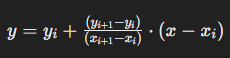

Donde:
- y es el valor interpolado que queremos encontrar.
- x es el punto en el cual queremos interpolar.
- 𝑥𝑖+1 son los puntos conocidos entre los cuales estamos interpolando.
- 𝑦𝑖 y 𝑦𝑖+1 son los valores conocidos en 𝑥𝑖 y 𝑥𝑖+1, respectivamente.

**y = temperaturas**

**x = dias**

Temperatura en el día 10.0 según la Interpolación Lineal a Trozos: 26.0


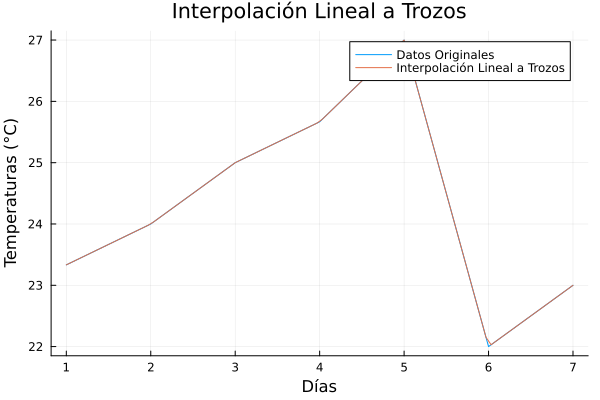

In [26]:
function InterpolacionTrozos(dias, temperaturas, cantidad_interpolar, lagrange = false)
    # Obtiene el valor de las listas y busca el valor interpolado de la temperatura a partir de la cantidad de interpolación
    # Encontrar el intervalo correcto
    for i in 1:length(dias)-1
        # Recorre los dias hasta encontrar el intervalo de dias que corresponda a la cantidad de interpolación
        if cantidad_interpolar >= dias[i] && cantidad_interpolar <= dias[i+1]
            # Calcular la interpolación lineal
            if lagrange == false
                return temperaturas[i] + ((temperaturas[i+1] - temperaturas[i]) * (cantidad_interpolar - dias[i]) / (dias[i+1] - dias[i]))
            else
                return LagrangePolinomica(dias[i:i+1], temperaturas[i:i+1], cantidad_interpolar)
            end
        end
    end
    # Casos usados para obtener la interpolación en dias que no estan incluidos dentro de la lista inicial de dias, predicción de datos
    # Caso especial: extrapolación hacia la izquierda
    if cantidad_interpolar < dias[1]
        if lagrange == false
            return temperaturas[1] + ((temperaturas[2] - temperaturas[1]) * (cantidad_interpolar - dias[1]) / (dias[2] - dias[1]))
        else
            return LagrangePolinomica(dias[1:2], temperaturas[1:2], cantidad_interpolar)
        end
    end
    # Caso especial: extrapolación hacia la derecha
    if cantidad_interpolar > dias[end]
        if lagrange == false
            return temperaturas[end] + ((temperaturas[end] - temperaturas[end-1]) * (cantidad_interpolar - dias[end]) / (dias[end] - dias[end-1]))
        else
            return LagrangePolinomica(dias[end-1: end], temperaturas[end-1:end], cantidad_interpolar)
        end
    end
    return NaN  # Si la cantidad de interpolación está fuera del rango de dias
end

function PrintPrediction(dias, temperaturas, day, lagrange = false, label = "Lineal")
    #Función para imprimir la predicción de la temperatura en un día específico.
    prediction = InterpolacionTrozos(dias, temperaturas, day, lagrange)
    println("Temperatura en el día $day según la Interpolación $label a Trozos: ", prediction)
end

function PrintTemperaturasInterpoladas(dias, temperaturas, lagrange = false, label = "Lineal")
    #Función para imprimir las temperaturas interpoladas.
    # Crear puntos interpolados
    dias_interpolados = DiasInterpolados()
    temperaturas_interpoladas = [InterpolacionTrozos(dias, temperaturas, cantidad_interpolar, lagrange) for cantidad_interpolar in dias_interpolados]

    # Graficar los puntos originales y la interpolación
    plot(dias, temperaturas, label="Datos Originales", xlabel="Días", ylabel="Temperaturas (°C)", title="Interpolación $label a Trozos")
    plot!(dias_interpolados, temperaturas_interpoladas, label="Interpolación $label a Trozos")
end

PrintPrediction(dias, temperaturas, day)
PrintTemperaturasInterpoladas(dias, temperaturas)


Interpolación Polinómica a Trozos con Lagrange

Temperatura en el día 10.0 según la Interpolación Polinomica con Lagrange a Trozos: 26.0


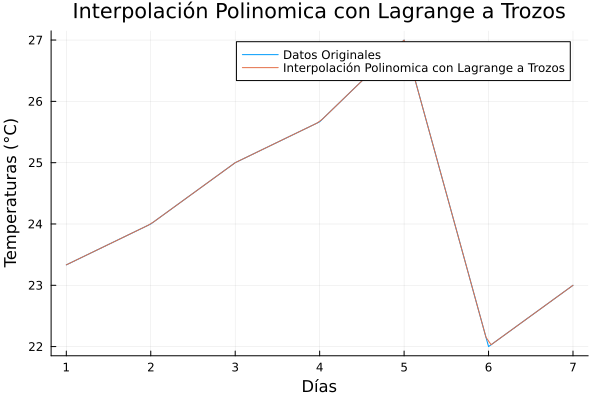

In [27]:
label = "Polinomica con Lagrange"
PrintPrediction(dias, temperaturas, day, true, label)
PrintTemperaturasInterpoladas(dias, temperaturas, true, label)